# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

request.headers.Host                         request.headers.User-Agent  \
0       127.0.0.1:5000  Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...   
1       127.0.0.1:5000  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
2       127.0.0.1:5000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...   
3       127.0.0.1:5000  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...   
4       127.0.0.1:5000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...   

  request.headers.Accept-Encoding request.headers.Accept  \
0               gzip, deflate, br                    */*   
1               gzip, deflate, br                    */*   
2               gzip, deflate, br                    */*   
3               gzip, deflate, br                    */*   
4               gzip, deflate, br                    */*   

  request.headers.Connection request.headers.Accept-Language  \
0                 keep-alive                           de-CH   
1                 keep-alive         en-US,en;q=0.9,he;q=0.8   
2                 keep-alive                           de-CH   
3                 keep-alive                  en-US,en;q=0.5   
4                 keep-alive         en-US,en;q=0.9,he;q=0.8   

  request.headers.Sec-Fetch-Site request.headers.Sec-Fetch-Mode  \
0                           none                    same-origin   
1                           none                    same-origin   
2                           none                      websocket   
3                           none                    same-origin   
4                           none                      websocket   

  request.headers.Sec-Fetch-User request.headers.Sec-Fetch-Dest  \
0                             ?1                       document   
1                             ?1                       document   
2                             ?1                       document   
3                             ?1                       document   
4                             ?1                       document   

                          request.headers.Set-Cookie  \
0  ['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...   
1  ['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...   
2  ['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...   
3  ['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...   
4  ['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...   

            request.headers.Date request.method  \
0  Fri, 11 Nov 2022 03:12:09 GMT            GET   
1  Fri, 11 Nov 2022 03:01:18 GMT            GET   
2  Fri, 11 Nov 2022 03:01:17 GMT            GET   
3  Fri, 11 Nov 2022 02:40:48 GMT            GET   
4  Fri, 11 Nov 2022 03:05:42 GMT            GET   

                                       request.url request.body  \
0   http://127.0.0.1:5000/static/download_txt/7115                
1          http://127.0.0.1:5000/about/random_page                
2       http://127.0.0.1:5000/categories/check/all                
3                http://127.0.0.1:5000/states/5911                
4  http://127.0.0.1:5000/orders/get/ship_via/10642                

  response.status response.headers.Content-Type  \
0   404 NOT FOUND              application/json   
1          200 OK      text/html; charset=utf-8   
2          200 OK              application/json   
3   404 NOT FOUND              application/json   
4   404 NOT FOUND              application/json   

  response.headers.Content-Length  response.status_code  \
0                              32                   404   
1                            1163                   200   
2                            1112                   200   
3                              33                   404   
4                              36                   404   

                                       response.body  \
0                        {"error": "File not found"}   
1  <figure><img src="https://img-c.udemycdn.com/r...   
2  [{"category_id": "1", "category_name": "Bevera...   
3                       {"error": "State not found"}  

### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

request.headers.Host  \
0            127.0.0.1:5000   
1            127.0.0.1:5000   
2            127.0.0.1:5000   
3            127.0.0.1:5000   
4            127.0.0.1:5000   
...                     ...   
127495       127.0.0.1:5000   
127496       127.0.0.1:5000   
127497       127.0.0.1:5000   
127498       127.0.0.1:5000   
127499       127.0.0.1:5000   

                               request.headers.User-Agent  \
0       Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...   
1       Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
2       Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...   
3       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...   
4       Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...   
...                                                   ...   
127495  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
127496  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...   
127497  Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...   
127498  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....   
127499  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....   

       request.headers.Accept-Encoding request.headers.Accept  \
0                    gzip, deflate, br                    */*   
1                    gzip, deflate, br                    */*   
2                    gzip, deflate, br                    */*   
3                    gzip, deflate, br                    */*   
4                    gzip, deflate, br                    */*   
...                                ...                    ...   
127495               gzip, deflate, br                    */*   
127496               gzip, deflate, br                    */*   
127497               gzip, deflate, br                    */*   
127498               gzip, deflate, br                    */*   
127499               gzip, deflate, br                    */*   

       request.headers.Connection request.headers.Accept-Language  \
0                      keep-alive                           de-CH   
1                      keep-alive         en-US,en;q=0.9,he;q=0.8   
2                      keep-alive                           de-CH   
3                      keep-alive                  en-US,en;q=0.5   
4                      keep-alive         en-US,en;q=0.9,he;q=0.8   
...                           ...                             ...   
127495                 keep-alive                  en-US,en;q=0.5   
127496                 keep-alive                              de   
127497                 keep-alive                              de   
127498                 keep-alive                           de-CH   
127499                 keep-alive                           de-CH   

       request.headers.Sec-Fetch-Site request.headers.Sec-Fetch-Mode  \
0                                none                    same-origin   
1                                none                    same-origin   
2                                none                      websocket   
3                                none                    same-origin   
4                                none                      websocket   
...                               ...                            ...   
127495                           none                      websocket   
127496                           none                      websocket   
127497                           none                      websocket   
127498                           none                      websocket   
127499                           none                    same-origin   

       request.headers.Sec-Fetch-User request.headers.Sec-Fetch-Dest  \
0                                  ?1                       document   
1                                  ?1                       document   
2                                  ?1                       document   
3                                  ?1                       document   
4                                  ?1                       docume

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

request.headers.Host                         request.headers.User-Agent  \
0       127.0.0.1:5000  Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...   
1       127.0.0.1:5000  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
2       127.0.0.1:5000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...   
3       127.0.0.1:5000  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...   
4       127.0.0.1:5000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...   

  request.headers.Accept-Encoding request.headers.Accept  \
0               gzip, deflate, br                    */*   
1               gzip, deflate, br                    */*   
2               gzip, deflate, br                    */*   
3               gzip, deflate, br                    */*   
4               gzip, deflate, br                    */*   

  request.headers.Connection request.headers.Accept-Language  \
0                 keep-alive                           de-CH   
1                 keep-alive         en-US,en;q=0.9,he;q=0.8   
2                 keep-alive                           de-CH   
3                 keep-alive                  en-US,en;q=0.5   
4                 keep-alive         en-US,en;q=0.9,he;q=0.8   

  request.headers.Sec-Fetch-Site request.headers.Sec-Fetch-Mode  \
0                           none                    same-origin   
1                           none                    same-origin   
2                           none                      websocket   
3                           none                    same-origin   
4                           none                      websocket   

  request.headers.Sec-Fetch-User request.headers.Sec-Fetch-Dest  \
0                             ?1                       document   
1                             ?1                       document   
2                             ?1                       document   
3                             ?1                       document   
4                             ?1                       document   

                          request.headers.Set-Cookie  \
0  ['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...   
1  ['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...   
2  ['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...   
3  ['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...   
4  ['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...   

            request.headers.Date request.method  \
0  Fri, 11 Nov 2022 03:12:09 GMT            GET   
1  Fri, 11 Nov 2022 03:01:18 GMT            GET   
2  Fri, 11 Nov 2022 03:01:17 GMT            GET   
3  Fri, 11 Nov 2022 02:40:48 GMT            GET   
4  Fri, 11 Nov 2022 03:05:42 GMT            GET   

                                       request.url request.body  \
0   http://127.0.0.1:5000/static/download_txt/7115                
1          http://127.0.0.1:5000/about/random_page                
2       http://127.0.0.1:5000/categories/check/all                
3                http://127.0.0.1:5000/states/5911                
4  http://127.0.0.1:5000/orders/get/ship_via/10642                

  response.status response.headers.Content-Type  \
0   404 NOT FOUND              application/json   
1          200 OK      text/html; charset=utf-8   
2          200 OK              application/json   
3   404 NOT FOUND              application/json   
4   404 NOT FOUND              application/json   

  response.headers.Content-Length  response.status_code  \
0                              32                   404   
1                            1163                   200   
2                            1112                   200   
3                              33                   404   
4                              36                   404   

                                       response.body  \
0                        {"error": "File not found"}   
1  <figure><img src="https://img-c.udemycdn.com/r...   
2  [{"category_id": "1", "category_name": "Bevera...   
3                       {"error": "State not found"}  

In [4]:
# # Setting features for further feature extraction by choosing columns
# # Some will be "simply" encoded via label encoding and others with HashingVectorizer

# SIMPLE_HEADERS = [ 'request.method',
#                 'request.headers.Accept-Language',
#                 'request.headers.Sec-Fetch-Mode',
#     'request.headers.Sec-Fetch-Dest',
#     'request.headers.Sec-Fetch-Site'
#                 ]
# # On these headers we will run HashingVectorizer

# COMPLEX_HEADERS = ['response.headers.Content-Type','request.headers.User-Agent',
#                     'request.headers.Set-Cookie',
#                     'response.body',
#                    'request.headers.Date',
#                     'response.headers.Location',
#                     'request.headers.Cookie',
#                     ]


# COLUMNS_TO_REMOVE = ['request.headers.Accept-Encoding',
                     
#                      'response.status','response.status_code','response.headers.Set-Cookie',
#                      'request.headers.Content-Length']


SIMPLE_HEADERS = [ 'request.method',
# 
    'response.status_code',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Mode',
    'request.headers.Sec-Fetch-Dest',
    'request.headers.Sec-Fetch-Site'
                ]
# On these headers we will run HashingVectorizer

COMPLEX_HEADERS = ['response.headers.Content-Type','request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'response.body',
                   'request.headers.Date',
                    'response.headers.Location',
                    'request.headers.Cookie',
                   'response.headers.Set-Cookie',
                   'request.headers.Content-Length',
                     'request.headers.Accept-Encoding',
                    ]

COLUMNS_TO_REMOVE = [
  
                     
                     'response.status',
                     ]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):  
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df
df['response.headers.Content-Length'] = pd.to_numeric(df['response.headers.Content-Length'])
df = vectorize_df(df)
df.head()

request.headers.Host  request.headers.User-Agent  \
0       127.0.0.1:5000                   -0.755929   
1       127.0.0.1:5000                    0.000000   
2       127.0.0.1:5000                   -0.408248   
3       127.0.0.1:5000                    0.666667   
4       127.0.0.1:5000                   -0.471405   

   request.headers.Accept-Encoding request.headers.Accept  \
0                              0.0                    */*   
1                              0.0                    */*   
2                              0.0                    */*   
3                              0.0                    */*   
4                              0.0                    */*   

  request.headers.Connection  request.headers.Accept-Language  \
0                 keep-alive                                1   
1                 keep-alive                                3   
2                 keep-alive                                1   
3                 keep-alive                                2   
4                 keep-alive                                3   

   request.headers.Sec-Fetch-Site  request.headers.Sec-Fetch-Mode  \
0                               0                               0   
1                               0                               0   
2                               0                               1   
3                               0                               0   
4                               0                               1   

  request.headers.Sec-Fetch-User  request.headers.Sec-Fetch-Dest  \
0                             ?1                               0   
1                             ?1                               0   
2                             ?1                               0   
3                             ?1                               0   
4                             ?1                               0   

   request.headers.Set-Cookie  request.headers.Date  request.method  \
0                   -0.646997             -0.632456               0   
1                   -0.480384              0.000000               0   
2                    0.426401              0.316228               0   
3                   -0.593391             -0.316228               0   
4                   -0.652753             -0.471405               0   

                                       request.url request.body  \
0   http://127.0.0.1:5000/static/download_txt/7115                
1          http://127.0.0.1:5000/about/random_page                
2       http://127.0.0.1:5000/categories/check/all                
3                http://127.0.0.1:5000/states/5911                
4  http://127.0.0.1:5000/orders/get/ship_via/10642                

   response.headers.Content-Type  response.headers.Content-Length  \
0                           -1.0                               32   
1                           -1.0                             1163   
2                           -1.0                             1112   
3                           -1.0                               33   
4                           -1.0                               36   

   response.status_code  response.body  response.headers.Location  \
0                     4       0.408248                       -1.0   
1                     0       0.956183                       -1.0   
2                     0      -0.255551                       -1.0   
3                     4       0.408248                       -1.0   
4                     4       0.894427                       -1.0   

   request.headers.Cookie  request.headers.Content-Length  \
0                    -1.0                            -1.0   
1                    -1.0                            -1.0   
2                    -1.0                            -1.0   
3                    -1.0                            -1.0   
4                    -1.0                            -1.0   

   response.headers.Set-Cookie attack_type   label  
0              

# URL

In [5]:
from bs4 import BeautifulSoup
import urllib
import bs4
import re
import socket
import whois
from datetime import datetime
import time
# https://breakingcode.wordpress.com/2010/06/29/google-search-python/
# Previous package structure was modified. Import statements according to new structure added. Also code modified.
import googlesearch  as gs
# This import is needed only when you run this file in isolation.
import sys
from patterns import *
# Purpose - This file just stores all the regular expression patterns used in features_extraction.py so that there is
# a common source which can be used if any of the patterns are to be edited.

ipv4_pattern = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
ipv6_pattern = r"^(?:(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){6})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:::(?:(?:(?:[0-9a-fA-F]{1,4})):){5})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){4})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,1}(?:(?:[0-9a-fA-F]{1,4})))?::" \
               r"(?:(?:(?:[0-9a-fA-F]{1,4})):){3})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,2}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){2})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,3}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:[0-9a-fA-F]{1,4})):)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,4}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,5}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,6}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::))))$"
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
http_https = r"https://|http://"

In [6]:
# pip install whois

In [7]:
# pip install patterns

In [8]:
# pip install google-search

In [9]:
# !pip install google

In [10]:
def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 1 if match else 0


def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1


def url_length(url):
    if len(url) < 52:
        return 0
    else:
        return 1



def shortening_service(url):
    match = re.search(shortening_services, url)
    
    return 1 if match else 0


def having_at_symbol(url):
    match = re.search('@', url)
    return 1 if match else 0

def having_at_symbol2(url):
    match = re.search('%', url)
    return 1 if match else 0

def double_slash_redirecting(url):
    # since the position starts from 0, we have given 6 and not 7 which is according to the document.
    # It is convenient and easier to just use string search here to search the last occurrence instead of re.
    last_double_slash = url.rfind('//')
    return 1 if last_double_slash > 6 else 0


def prefix_suffix(domain):
    match = re.search('-', domain)
    return 1 if match else 0


def having_sub_domain(url):
    # Here, instead of greater than 1 we will take greater than 3 since the greater than 1 condition is when www and
    # country domain dots are skipped
    # Accordingly other dots will increase by 1
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 3:
        return 0
    else:
        return 1
#lalala
def abnormal_url(domain, url):
    hostname = domain
    match = re.search(hostname, url)
    return 0 if match else 1

def domain_registration_length(domain):
    expiration_date = domain.expiration_date
    today = time.strftime('%Y-%m-%d')
    today = datetime.strptime(today, '%Y-%m-%d')

    registration_length = 0
    # Some domains do not have expiration dates. This if condition makes sure that the expiration date is used only
    # when it is present.
    if expiration_date:
        registration_length = abs((expiration_date - today).days)
    return 1 if registration_length / 365 <= 1 else 0






In [11]:
def check_url(url,domain,wiki):
    print(url)
#     if having_ip_address(url) == 1:
#         return 1
    if url_length(url)  == 1:
        print("url_length")
        return 1
    elif shortening_service(url) == 1:
        print("shortening_service")
        return 1
    elif having_at_symbol(url) == 1:
        print("having_at_symbol")
        return 1
    elif having_at_symbol2(url) == 1:
        print("having_at_symbol2")
        return 1
    
    elif double_slash_redirecting(url)== 1:
        return 1
# lallal
    elif abnormal_url(domain, url)== 1:
             return 1

    elif prefix_suffix(domain)== 1:
        print("prefix_suffix") 
        return 1
    elif having_sub_domain(url)== 1:
        print("having_sub_domain")
        return 1
# lallal
#     elif domain_registration_length(domain)== 1:
#         return 1
# lallal
#     elif https_token(url)== 1:
#         return 1


    else:
        return 0

In [12]:
def get_hostname_from_url(url):
    
    hostname = url
    # TODO: Put this pattern in patterns.py as something like - get_hostname_pattern.
    pattern = "https://|http://|www.|https://www.|http://www."
    pre_pattern_match = re.search(pattern, hostname)

    if pre_pattern_match:
        hostname = hostname[pre_pattern_match.end():]
        post_pattern_match = re.search("/", hostname)
        if post_pattern_match:
            hostname = hostname[:post_pattern_match.start()]

    return hostname

In [13]:

# hostname=get_hostname_from_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt")
# domain = whois.query(hostname)
# print(check_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt",domain,hostname))

In [14]:
def change_url(df):  
    df_url=[]
    for index, row in df.iterrows():
        url=row["request.url"]
        hostname=get_hostname_from_url(url)
        domain=""
        try:
            domain = whois.query(hostname)
        except:
             dns = -1
        df_url.append(check_url(url,domain,hostname))

    # print(df.length())
    # print(df_url)
    # for index, row in df.iterrows():
    df["request.url"] =df_url
    return df


In [15]:

change_url(df)

http://127.0.0.1:5000/static/download_txt/7115
http://127.0.0.1:5000/about/random_page
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/states/5911
http://127.0.0.1:5000/orders/get/ship_via/10642
http://127.0.0.1:5000/orders/get/country/2945
http://127.0.0.1:5000/post/new
http://127.0.0.1:5000/post/new/
http://127.0.0.1:5000/categories/check/name/1748
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/states/get/region/8974
http://127.0.0.1:5000/categories/check/number/5329
http://127.0.0.1:5000/about/random_page
http://127.0.0.1:5000/states/4113
http://127.0.0.1:5000/orders/get/id/7687
http://127.0.0.1:5000/states/6648
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/greet/4921
http://127.0.0.1:5000/login/admin/password/3459
http://127.0.0.1:5000/
http://127.0.0.1:5000/states/2605
http://127.0.0.1:5000/static/download_txt/3870
http://127.0.0.1:5000/post/new/
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/states/get/region

request.headers.Host  request.headers.User-Agent  \
0            127.0.0.1:5000                   -0.755929   
1            127.0.0.1:5000                    0.000000   
2            127.0.0.1:5000                   -0.408248   
3            127.0.0.1:5000                    0.666667   
4            127.0.0.1:5000                   -0.471405   
...                     ...                         ...   
127495       127.0.0.1:5000                    0.000000   
127496       127.0.0.1:5000                   -0.471405   
127497       127.0.0.1:5000                    0.000000   
127498       127.0.0.1:5000                   -0.800000   
127499       127.0.0.1:5000                   -0.800000   

        request.headers.Accept-Encoding request.headers.Accept  \
0                                   0.0                    */*   
1                                   0.0                    */*   
2                                   0.0                    */*   
3                                   0.0                    */*   
4                                   0.0                    */*   
...                                 ...                    ...   
127495                              0.0                    */*   
127496                              0.0                    */*   
127497                              0.0                    */*   
127498                              0.0                    */*   
127499                              0.0                    */*   

       request.headers.Connection  request.headers.Accept-Language  \
0                      keep-alive                                1   
1                      keep-alive                                3   
2                      keep-alive                                1   
3                      keep-alive                                2   
4                      keep-alive                                3   
...                           ...                              ...   
127495                 keep-alive                                2   
127496                 keep-alive                                0   
127497                 keep-alive                                0   
127498                 keep-alive                                1   
127499                 keep-alive                                1   

        request.headers.Sec-Fetch-Site  request.headers.Sec-Fetch-Mode  \
0                                    0                               0   
1                                    0                               0   
2                                    0                               1   
3                                    0                               0   
4                                    0                               1   
...                                ...                             ...   
127495                               0                               1   
127496                               0                               1   
127497                               0                               1   
127498                               0                               1   
127499                               0                               0   

       request.headers.Sec-Fetch-User  request.headers.Sec-Fetch-Dest  \
0                                  ?1                               0   
1                                  ?1                               0   
2                                  ?1                               0   
3                                  ?1                               0   
4                                  ?1                               0   
...                               ...                             ...   
127495                             ?1                               0   
127496                             ?1                               0   
127497                             ?1                               0   
127498                             ?1        

In [16]:
print (df["request.url"])

0         0
1         0
2         0
3         0
4         0
         ..
127495    0
127496    0
127497    0
127498    0
127499    0
Name: request.url, Length: 127500, dtype: int64


In [17]:
# removing columns with the same values
print("Before: " ,df.shape)
for col in df.columns:
    if len(df[col].unique()) == 1:
        # print("col drop: ",col)
        df = df.drop(col,axis=1)

print("After: " ,df.shape)

Before:  (127500, 25)
After:  (127500, 19)


In [18]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.User-Agent       127500 non-null  float64
 1   request.headers.Accept-Encoding  127500 non-null  float64
 2   request.headers.Accept-Language  127500 non-null  int32  
 3   request.headers.Sec-Fetch-Site   127500 non-null  int32  
 4   request.headers.Sec-Fetch-Mode   127500 non-null  int32  
 5   request.headers.Sec-Fetch-Dest   127500 non-null  int32  
 6   request.headers.Set-Cookie       127500 non-null  float64
 7   request.headers.Date             127500 non-null  float64
 8   request.method                   127500 non-null  int32  
 9   request.url                      127500 non-null  int64  
 10  response.headers.Content-Length  127500 non-null  int64  
 11  response.status_code             127500 non-null  int64  
 12  re

In [19]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.headers.Date', 'request.method', 'request.url', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie']


request.headers.User-Agent         float64
request.headers.Accept-Encoding    float64
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.headers.Date               float64
request.method                       int32
request.url                          int64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                      float64
response.headers.Location          float64
request.headers.Cookie             float64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [20]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 17) (104996,)
(22504, 17) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

In [21]:
df

request.headers.User-Agent  request.headers.Accept-Encoding  \
0                        -0.755929                              0.0   
1                         0.000000                              0.0   
2                        -0.408248                              0.0   
3                         0.666667                              0.0   
4                        -0.471405                              0.0   
...                            ...                              ...   
127495                    0.000000                              0.0   
127496                   -0.471405                              0.0   
127497                    0.000000                              0.0   
127498                   -0.800000                              0.0   
127499                   -0.800000                              0.0   

        request.headers.Accept-Language  request.headers.Sec-Fetch-Site  \
0                                     1                               0   
1                                     3                               0   
2                                     1                               0   
3                                     2                               0   
4                                     3                               0   
...                                 ...                             ...   
127495                                2                               0   
127496                                0                               0   
127497                                0                               0   
127498                                1                               0   
127499                                1                               0   

        request.headers.Sec-Fetch-Mode  request.headers.Sec-Fetch-Dest  \
0                                    0                               0   
1                                    0                               0   
2                                    1                               0   
3                                    0                               0   
4                                    1                               0   
...                                ...                             ...   
127495                               1                               0   
127496                               1                               0   
127497                               1                               0   
127498                               1                               0   
127499                               0                               0   

        request.headers.Set-Cookie  request.headers.Date  request.method  \
0                        -0.646997             -0.632456               0   
1                        -0.480384              0.000000               0   
2                         0.426401              0.316228               0   
3                        -0.593391             -0.316228               0   
4                        -0.652753             -0.471405               0   
...                            ...                   ...             ...   
127495                   -0.303046              0.000000               0   
127496                   -0.125988              0.000000               0   
127497                   -0.363803              0.000000               0   
127498                   -0.356348             -0.223607               0   
127499                   -0.374634             -0.235702               0   

        request.url  response.headers.Content-Length  response.status_code  \
0                 0                               32                     4   
1                 0                             1163                     0   
2                 0                             1112                     0   
3                 0                               33                     4   
4                 0                               36          

## Model choosing and fitting

In [22]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 97102), ('Malware', 7894)]


In [23]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

## Result printout

              precision    recall  f1-score   support

      Benign    0.99298   0.99976   0.99636     20812
     Malware    0.99677   0.91312   0.95312      1692

    accuracy                        0.99325     22504
   macro avg    0.99488   0.95644   0.97474     22504
weighted avg    0.99327   0.99325   0.99311     22504



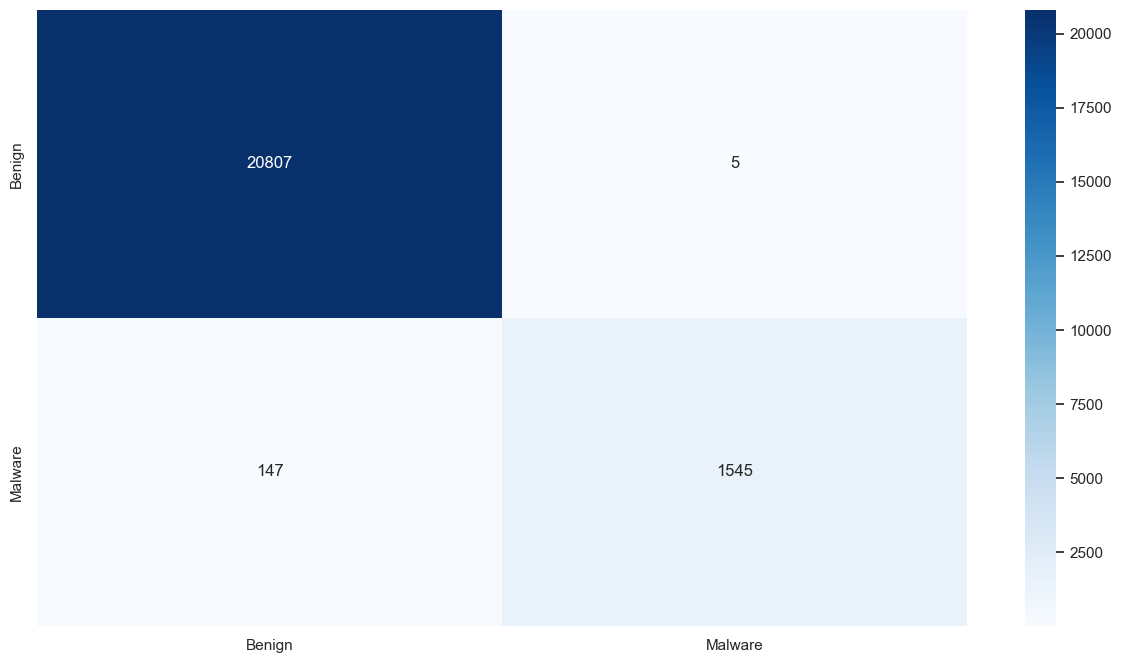

In [24]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

[('Benign', 97102), ('Malware', 7894)]
              precision    recall  f1-score   support

      Benign    0.99299   0.99986   0.99641     20812
     Malware    0.99806   0.91312   0.95370      1692

    accuracy                        0.99333     22504
   macro avg    0.99552   0.95649   0.97506     22504
weighted avg    0.99337   0.99333   0.99320     22504



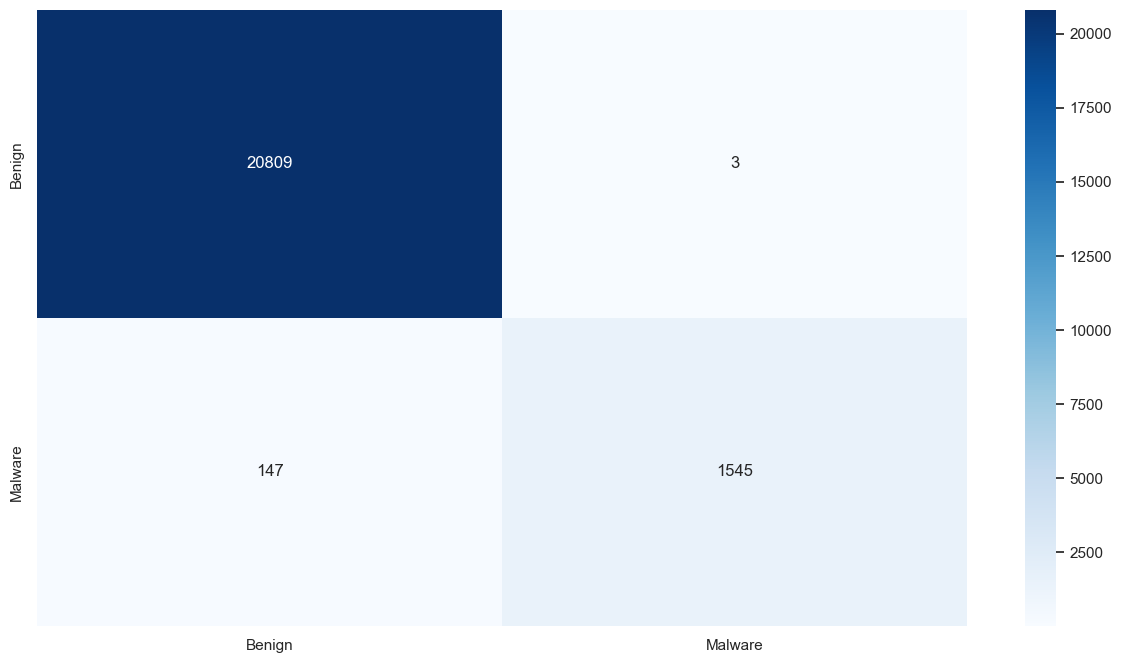

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# We choose our model of choice and set it's hyper parameters you can change anything
rfc = RandomForestClassifier()

parameters = {"n_estimators": [100,150,250,275,300,325,350,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
rfc = GridSearchCV(clf, parameters)
# Train Model
rfc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
rfc = rfc.best_estimator_
ResultPrintout(rfc)

Feature: 0, Score: 0.01260
Feature: 1, Score: 0.01084
Feature: 2, Score: 0.00528
Feature: 3, Score: 0.02302
Feature: 4, Score: 0.00203
Feature: 5, Score: 0.02244
Feature: 6, Score: 0.04496
Feature: 7, Score: 0.01167
Feature: 8, Score: 0.01334
Feature: 9, Score: 0.33340
Feature: 10, Score: 0.17575
Feature: 11, Score: 0.06702
Feature: 12, Score: 0.06179
Feature: 13, Score: 0.01831
Feature: 14, Score: 0.14677
Feature: 15, Score: 0.02601
Feature: 16, Score: 0.02478


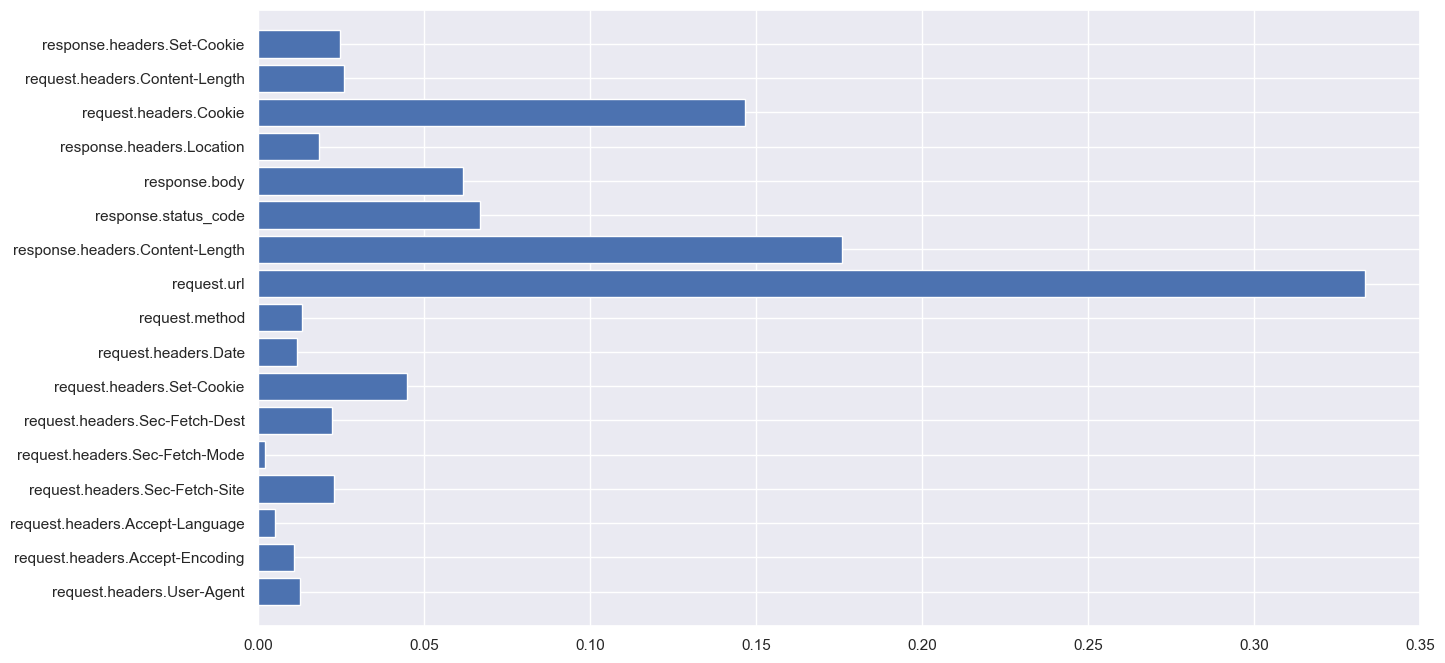

In [26]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

In [27]:
print(df['response.headers.Content-Length'])

0           32
1         1163
2         1112
3           33
4           36
          ... 
127495      39
127496      70
127497      70
127498     207
127499     350
Name: response.headers.Content-Length, Length: 127500, dtype: int64


In [28]:
# import xgboost as xgb
# # We choose our model of choice and set it's hyper parameters you can change anything
# xg = xgb.XGBClassifier(objective="binary:logistic", random_state=45)
# xg.fit(X_train, y_train)

# # Check data balance and variety
# print(sorted(Counter(y_train).items()))
# ResultPrintout(xg)

In [29]:
# # https://machinelearningmastery.com/calculate-feature-importance-with-python/
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot

# # get importance
# importance = xg.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#  print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# # pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.yticks(np.arange(X_train.shape[1]), features_list)
# pyplot.ylim([-1, X_train.shape[1]])
# pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
# pyplot.show()

[('Benign', 97102), ('Malware', 7894)]
              precision    recall  f1-score   support

      Benign    0.99299   1.00000   0.99648     20812
     Malware    1.00000   0.91312   0.95459      1692

    accuracy                        0.99347     22504
   macro avg    0.99649   0.95656   0.97553     22504
weighted avg    0.99351   0.99347   0.99333     22504



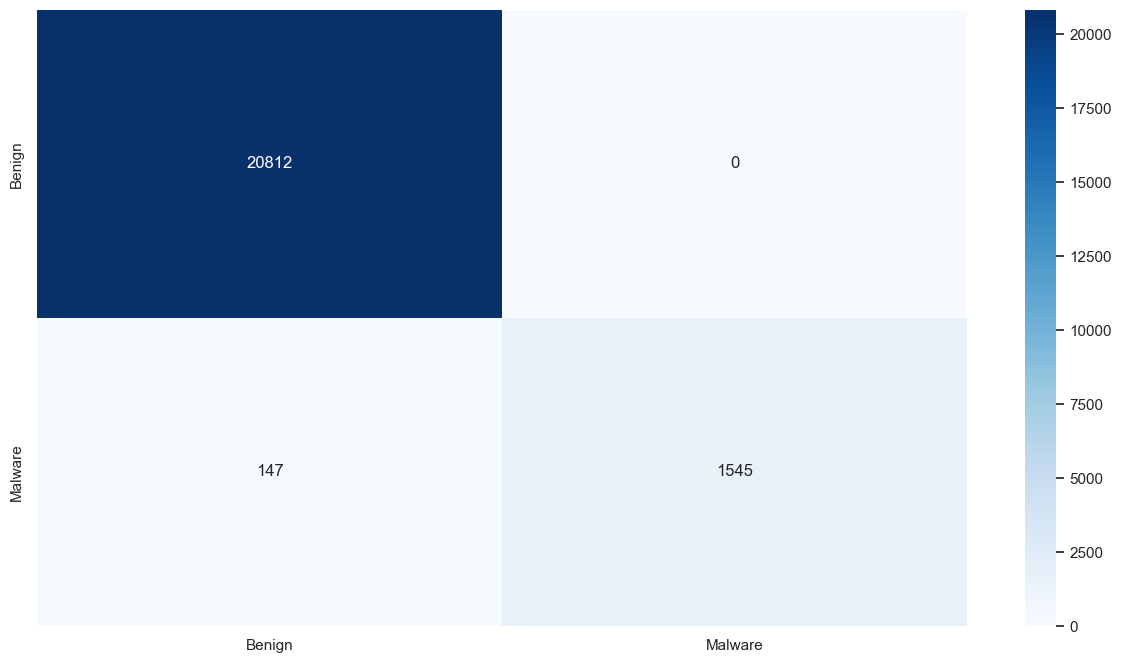

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import HistGradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
hgbc = HistGradientBoostingClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"min_samples_leaf": [1,5,10,15,20],
              "max_iter":[1,2,3,4,5,10,20,50,100]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
hgbc = GridSearchCV(hgbc, parameters)
hgbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
hgbc = hgbc.best_estimator_
ResultPrintout(hgbc)

C:\Users\97252\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              precision    recall  f1-score   support

      Benign    0.99299   1.00000   0.99648     20812
     Malware    1.00000   0.91312   0.95459      1692

    accuracy                        0.99347     22504
   macro avg    0.99649   0.95656   0.97553     22504
weighted avg    0.99351   0.99347   0.99333     22504

ExtraTreesClassifier(class_weight='balanced', random_state=42)
              precision    r

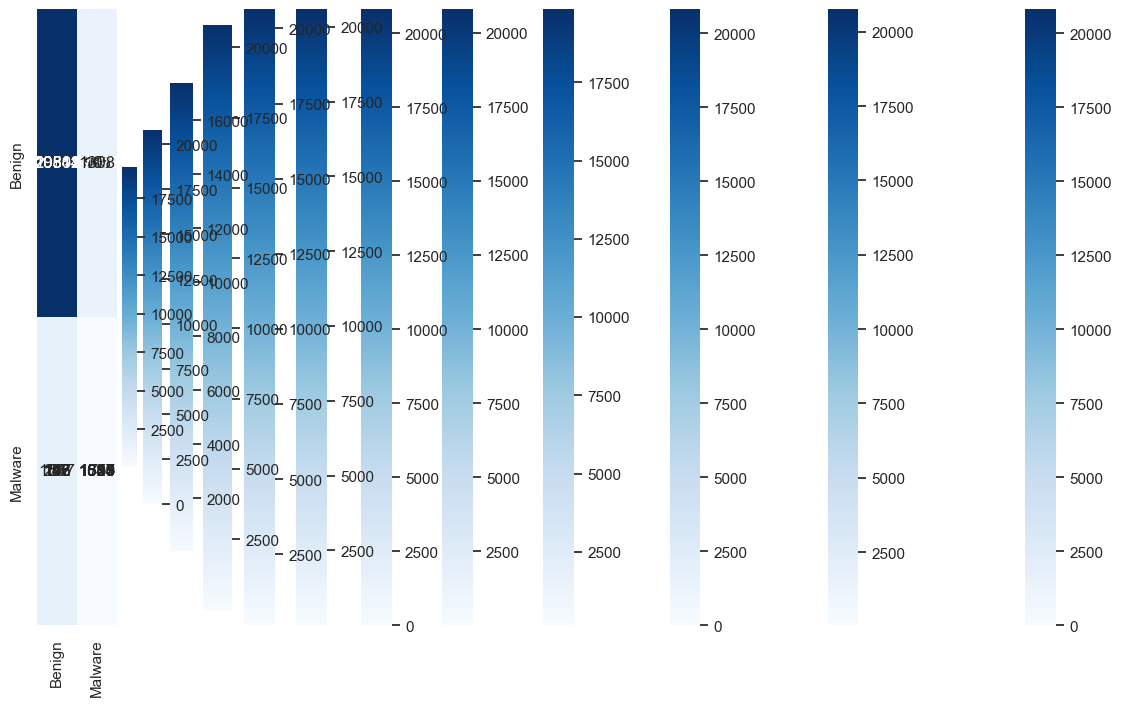

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
import xgboost 
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline


Logistic_Regression =  LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

Decision_Tree =DecisionTreeClassifier(random_state=42, class_weight='balanced')

Random_Forest =  RandomForestClassifier(random_state=42, class_weight='balanced')

Extra_Trees=  ExtraTreesClassifier(random_state=42, class_weight='balanced')

Gradient_Boosting =  GradientBoostingClassifier(random_state=42)

Hist_Gradient_Boosting =  HistGradientBoostingClassifier(random_state=42)

AdaBoost = AdaBoostClassifier(random_state=42)

SGD = SGDClassifier(random_state=42, class_weight='balanced')

SVC =SVC(class_weight='balanced', random_state=42)

Nearest_Neighbor = KNeighborsClassifier(100)

Perceptron = Perceptron(random_state=42)
xgb=xgboost.sklearn.XGBClassifier(max_depth=2)
models={xgb,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost,SGD,SVC,Nearest_Neighbor,Perceptron}

for model in models:
#     %time scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('* %s Score = %.3f StdDev = (%.3f)' % (name, np.mean(scores), np.std(scores)), '\n')
#     hgbc2 = HistGradientBoostingClassifier()

   
    # Train Model
    model.fit(X_train, y_train)
    print(model)
    # # Check data balance and variety
    ResultPrintout(model)


In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,rfc,hgbc,xgb,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost,SGD,SVC,Nearest_Neighbor,Perceptron}

for i in models:
    print(i)
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    print(accuracy_score(true_labels, predictions)*100)
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
#         print(best)
#         print(m)
        
print("-------")
print(best)
print(m)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
99.34678279416993
ExtraTreesClassifier(class_weight='balanced', random_state=42)
99.13793103448276
AdaBoostClassifier(random_state=42)
99.2667970138642
SGDClassifier(class_weight='balanced', random_state=42)
87.00231070031994
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
94.9742268041237
RandomForestClassifier()
99.32456452186278
RandomForestClassifier(class_weight='balanced', random_s

# Test

In [33]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)
change_url(test_df)
# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)


http://127.0.0.1:5000/login/user/6963
http://127.0.0.1:5000/login/admin/password/10311
http://127.0.0.1:5000/login/user/1956
http://127.0.0.1:5000/static/download_txt/6611
http://127.0.0.1:5000/orders/get/id/9034
http://127.0.0.1:5000/orders/get/employee_id/3535
http://127.0.0.1:5000/static/download_txt/7172
http://127.0.0.1:5000/login/admin/password/5232
http://127.0.0.1:5000/categories/check/name/7518
http://127.0.0.1:5000/login/admin/password/7575
http://127.0.0.1:5000/states/get/region/8300
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20categories%20--
url_length
http://127.0.0.1:5000/post/new/
http://127.0.0.1:5000/greet/4474
http://127.0.0.1:5000/forgot-password/bookstore/api/swagger.json/2705
url_length
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/orders/get/id/9626
http://127.0.0.1:5000/states/1278
http://127.0.0.1:5000/static/download_txt/10127
http://127.0.0.1:5000/orders/check/exists/1344
http://127.0.0.1:5000/orders/get/employee_i

# Save your predictions

In [34]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')